In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.settings import *
import pickle as pkl
import json5 as json
import gzip
from src.tools.vis_utils import VisualizationConfig, FIGSIZE, visualize_dendrogram, plot_hexagons_map, plot_clusters
from src.tools.dim_reduction import reduce_umap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import wandb
import pandas as pd
import dataclasses
from scipy.cluster.hierarchy import cut_tree


In [3]:
run_name = "lunar-cloud-28"
run_dir = RUNS_DATA_DIR / run_name

with gzip.open(run_dir / "dataset.pkl.gz", "rb") as f:
    ds = pkl.load(f)

z_df = pd.read_pickle(run_dir / "embeddings.pkl.gz")

In [4]:
ds.__annotations__

{'config': src.tools.configs.DatasetGenerationConfig,
 'cities': pandas.core.frame.DataFrame,
 'edges': geopandas.geodataframe.GeoDataFrame,
 'hexagons': geopandas.geodataframe.GeoDataFrame,
 'hex_agg': typing.Optional[pandas.core.frame.DataFrame],
 'hex_agg_normalized': typing.Optional[pandas.core.frame.DataFrame]}

In [5]:
z_df

z_0       z_1       z_2  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff  0.124208  0.194689 -0.074610   
                            891f5104d2bffff  0.118608  0.184916 -0.080500   
                            891f5104d37ffff  0.131168  0.208779 -0.068117   
                            891f5104da7ffff  0.122211  0.384337 -0.075812   
                            891f5104db7ffff  0.299792  0.356743 -0.027914   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff  0.116403  0.186458 -0.078606   
                            891f5249babffff  0.106758  0.308505 -0.027701   
                            891f5249bafffff  0.115555  0.204643 -0.032727   
                            891f5249bb3ffff  0.115152  0.193467 -0.079548   
                            891f5249bb7ffff  0.125410  0.194444 -0.080834   

                                                  z_3       z_4       z_5  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff  0.044054 -0.039683  0.041708   
                            891f5104d2bffff  0.009698 -0.044003  0.042888   
                            891f5104d37ffff  0.052223 -0.045165  0.053481   
                            891f5104da7ffff -0.099493 -0.138845  0.034786   
                            891f5104db7ffff -0.137107  0.094055 -0.022742   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff  0.055174 -0.006328  0.004205   
                            891f5249babffff -0.097797 -0.138470 -0.032525   
                            891f5249bafffff -0.002053 -0.001771 -0.046545   
                            891f5249bb3ffff  0.030484 -0.021072 -0.005272   
                            891f5249bb7ffff  0.027984  0.002084 -0.012792   

                                                  z_6       z_7       z_8  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff  0.069022  0.129544 -0.077204   
                            891f5104d2bffff  0.069457  0.130356 -0.078252   
                            891f5104d37ffff  0.062665  0.152941 -0.097856   
                            891f5104da7ffff -0.045753  0.167726 -0.057619   
                            891f5104db7ffff  0.155229 -0.007342 -0.019786   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff  0.017478  0.131798 -0.090611   
                            891f5249babffff -0.079868  0.159870 -0.054861   
                            891f5249bafffff -0.009590  0.102094 -0.051052   
                            891f5249bb3ffff  0.025926  0.117219 -0.063800   
                            891f5249bb7ffff  0.006886  0.112064 -0.070343   

                                                  z_9  ...      z_20  \
continent country city      h3_id                      ...             
Europe    Poland  Białystok 891f5104d23ffff  0.041938  ... -0.127597   
                            891f5104d2bffff  0.047286  ... -0.128662   
                            891f5104d37ffff  0.039575  ... -0.162741   
                            891f5104da7ffff -0.012303  ... -0.143521   
                            891f5104db7ffff -0.020760  ... -0.399041   
...                                               ...  ...       ...   
                  Łódź      891f5249ba7ffff  0.062603  ... -0.028798   
                            891f5249babffff  0.033027  ... -0.010071   
                            891f5249bafffff  0.074064  ...  0.043111   
                            891f5249bb3ffff  0.058236  ...  0.001222   
                            891f5249bb7ffff  0.061393  ...  0.011700   

                                                 z_21      z_22      z_23  \
continent country city      h3

In [6]:
# TODO: reinit wandb project

In [18]:
vc = VisualizationConfig(
    n_clusters=None,
    distance_threshold=0,
    affinity="euclidean",
    linkage="ward",
    truncate_mode="level",
    p=5,
    clusters=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    cities_to_plot=["Wrocław"],
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_metric="euclidean",
)

vis_dir = run_dir / "vis"
vis_dir.mkdir(parents=True, exist_ok=True)

with open(vis_dir / "vis_config.json", "w") as f:
    json.dump(dataclasses.asdict(vc), f, indent=2, quote_keys=True, trailing_commas=False)

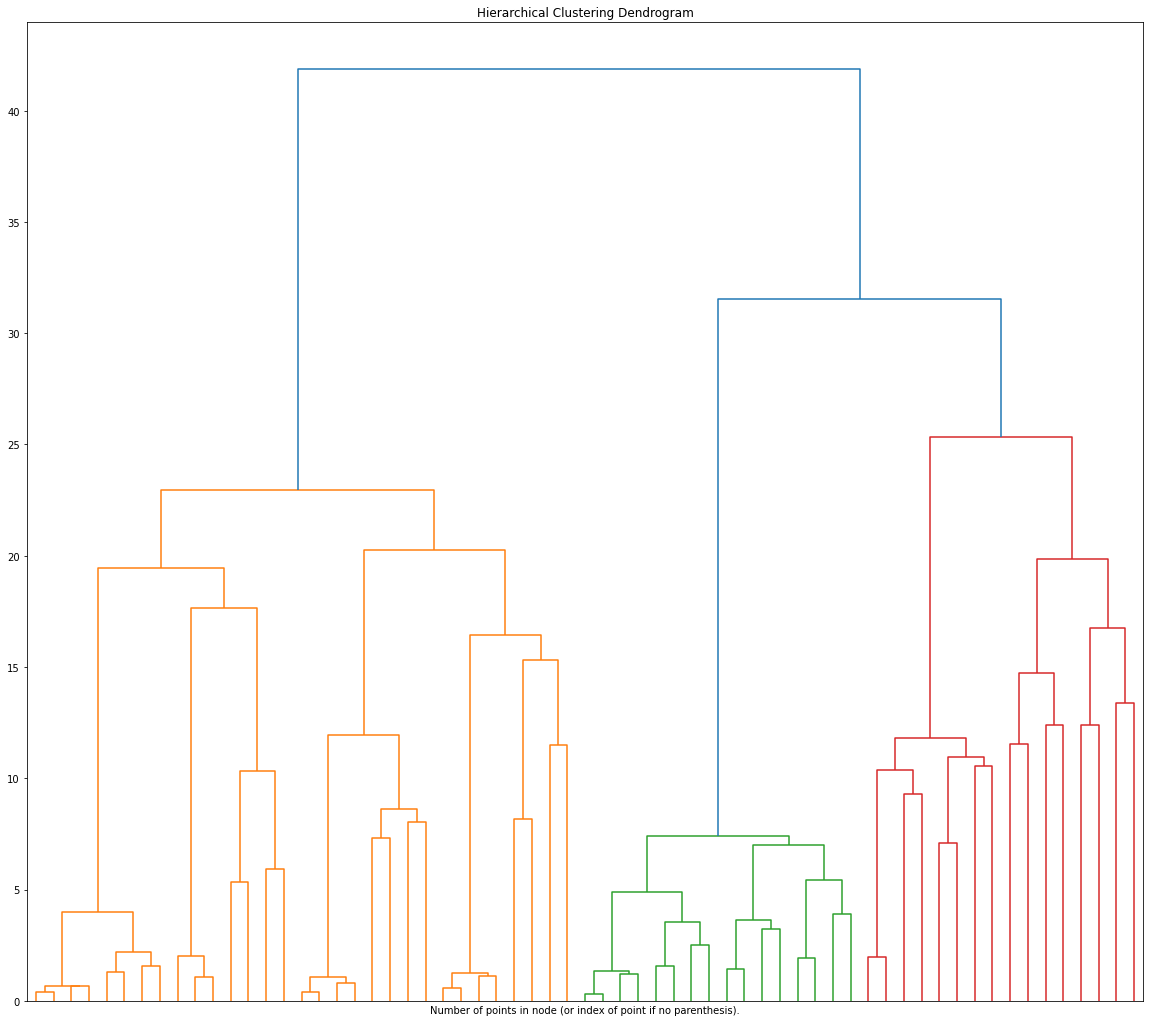

In [8]:

dendrogram_path = vis_dir / "dendrogram.png"

ac_model = AgglomerativeClustering(n_clusters=vc.n_clusters, distance_threshold=vc.distance_threshold, affinity=vc.affinity, linkage=vc.linkage)
ac_model.fit(z_df)
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

linkage_matrix = visualize_dendrogram(ac_model, truncate_mode=vc.truncate_mode, p=vc.p, ax=ax, no_labels=True)

fig.savefig(dendrogram_path)
plt.show()

In [11]:
hexagons = ds.hexagons
z_df_with_clusters = z_df.copy()
cut_tree_results = cut_tree(linkage_matrix, n_clusters = vc.clusters)

for index, c in enumerate(vc.clusters):
    assigned_clusters = cut_tree_results[:, index]
    z_df_with_clusters[f"cluster_{c}"] = pd.Series(assigned_clusters, index=z_df.index).astype("category")

hexagons_clustered = hexagons.join(z_df_with_clusters[[f"cluster_{c}" for c in vc.clusters]]).dropna().set_crs(epsg=4326)
hexagons_clustered.head(3)


coordinates  \
continent country city      h3_id                                                      
Europe    Poland  Białystok 891f51335a7ffff  (53.13378428677438, 23.198834404101717)   
                            891f51a9b6fffff  (53.13685044196499, 23.170395246099147)   
                            891f5106997ffff  (53.14056625128815, 23.110736734534687)   

                                                      parent  \
continent country city      h3_id                              
Europe    Poland  Białystok 891f51335a7ffff  881f51335bfffff   
                            891f51a9b6fffff  881f51a9b7fffff   
                            891f5106997ffff  881f510699fffff   

                                                                                      children  \
continent country city      h3_id                                                                
Europe    Poland  Białystok 891f51335a7ffff  {'8a1f51335a67fff', '8a1f51335a57fff', '8a1f51...   
                            891f51a9b6fffff  {'8a1f51a9b6effff', '8a1f51a9b6cffff', '8a1f51...   
                            891f5106997ffff  {'8a1f51069947fff', '8a1f5106995ffff', '8a1f51...   

                                             resolution  \
continent country city      h3_id                         
Europe    Poland  Białystok 891f51335a7ffff           9   
                            891f51a9b6fffff           9   
                            891f5106997ffff           9   

                                                                                      geometry  \
continent country city      h3_id                                                                
Europe    Poland  Białystok 891f51335a7ffff  POLYGON ((23.19629 53.13466, 23.19618 53.13302...   
                            891f51a9b6fffff  POLYGON ((23.16785 53.13772, 23.16774 53.13609...   
                            891f5106997ffff  POLYGON ((23.10819 53.14144, 23.10808 53.13980...   

                                            cluster_2 cluster_3 cluster_4  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f51335a7ffff         0         0         0   
                            891f51a9b6fffff         0         0         0   
                            891f5106997ffff         0         0         0   

                                            cluster_5 cluster_6  ...  \
continent country city      h3_id                                ...   
Europe    Poland  Białystok 891f51335a7ffff         0         0  ...   
                            891f51a9b6fffff         0         0  ...   
                            891f5106997ffff         0         0  ...   

                                            cluster_11 cluster_12 cluster_13  \
continent country city      h3_id                                              
Europe    Poland  Białystok 891f51335a7ffff          0          0          0   
                            891f51a9b6fffff          0          0          0   
                            891f5106997ffff          0          0          0   

                                            cluster_14 cluster_15 cluster_16  \
continent country city      h3_id                                              
Europe    Poland  Białystok 891f51335a7ffff          0          0          6   
                            891f51a9b6fffff          0          0          6   
                            891f5106997ffff          0          0          0   

                                            cluster_17 cluster_18 cluster_19  \
continent country city      h3_id                                              
Europe    Poland  Białystok 891f51335a7ffff          7          7          7   
                            891f51a9b6fffff          7          7          7   
                            891f5106997ffff          0          0          0   

                                            cluster_20  
continent country city    

In [12]:
df_clusters = z_df_with_clusters[[f"cluster_{c}" for c in vc.clusters]]
df_clusters.to_pickle(vis_dir / "clusters.pkl.gz")

In [13]:
cities_to_plot = ["Wrocław"]
hexagons_dir = vis_dir / "hexagons"
hexagons_dir.mkdir(parents=True, exist_ok=True)
for ctp in cities_to_plot:
    for c in vc.clusters:
        ax = plot_hexagons_map(hexagons_clustered.loc[:, :, ctp], ds.edges.loc[:, :, ctp], f"cluster_{c}")
        plt.savefig(hexagons_dir / f"{ctp}_cluster_{c}.png")
        plt.close()

In [20]:
from src.tools.vis_utils import visualize_kepler
config_name = "clusters"
m = visualize_kepler(ds.hexagons, config_name=config_name)
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data':                                                                          coordinates  \…

In [17]:
umap_dir = vis_dir / "umap"
umap_dir.mkdir(parents=True, exist_ok=True)
z_df_umaped = reduce_umap(z_df, n_components=vc.umap_n_components, n_neighbors=vc.umap_n_neighbours, metric=vc.umap_metric)[0]
for c in vc.clusters:
    cluster_to_show = f"cluster_{c}"
    z_df_umaped["cluster"] = z_df_with_clusters[cluster_to_show]
    fig = plot_clusters(z_df_umaped)
    fig.write_image(umap_dir / f"umap_{c}.png")

In [ ]:
# hexagons_clustered_agg = hex_agg
# hexagons_clustered_agg["cluster_10"] = hexagons_clustered["cluster_10"]
# hexagons_clustered_agg

In [ ]:
# hex_tfidf_by_cluster_mean = hex_tfidf_by_cluster.mean().reset_index()
# hex_tfidf_by_cluster_mean

In [ ]:
# import plotly.graph_objects as go

# features_selected = featureset_selection_config["features"]
# fig = go.Figure()
# for feature_name in features_selected.keys():
#     # print(feature_name)
#     feature_group = list(filter(lambda x: feature_name in x, hexagons_clustered_agg.columns))
#     for feature in feature_group:
#         fig.add_trace(go.Box(
#             x=hexagons_clustered_agg['cluster_10'],
#             y=hexagons_clustered_agg[feature],
#             name=feature
#         ))

#     # fig = px.box(hexagons_clustered_agg, boxmode="group", x="cluster_10", y=feature_group, width=1300, title=feature_name)
#     fig.update_layout(
#         xaxis = dict(
#             tickmode = 'linear',
#         ),
#         boxmode='group'
#     )
#     fig.show()

In [ ]:
# features_selected = featureset_selection_config["features"]
# for feature_name in features_selected.keys():
#     # print(feature_name)
#     feature_group = list(filter(lambda x: feature_name in x, hexagons_clustered_agg.columns))
#     fig = px.bar(hexagons_clustered_agg, x="cluster_10", y=feature_group, width=1300, title=feature_name)
#     fig.update_layout(
#         xaxis = dict(
#             tickmode = 'linear',
#         )
#     )
#     fig.show()